In [187]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Load dataset

In [188]:
credit_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', sep=',', header=None)
credit_data.columns=['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed',
                     'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'ApprovalStatus']

#replace + with Yes, else No
credit_data['ApprovalStatus'] = np.where(credit_data['ApprovalStatus']=='+', 'Yes', 'No')


def fill_missing(df):
    df.replace('?', np.NaN, inplace=True)
    for col in df.columns:
        if df[col].dtype=='object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        elif df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            print('Data Type error')

fill_missing(credit_data)

def change_type(df):
    for col in df:
        if col=='Age':
            df[col] = df[col].astype('float64')
        if df[col].dtype=='object':
            df[col] = df[col].astype('category')
        else:
            pass

change_type(credit_data)

def dummyVar(df):
    dummy_cols =[]
    for col in df:
        if df[col].dtype.name=='category':
            if df[col].nunique()>2:
                dummy_cols.append(col)
                
    return dummy_cols
    

dummyVar=dummyVar(credit_data)

In [189]:
credit_data.describe(include='all')

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
count,690,690.000000,690.000000,690,690,690,690,690.000000,690,690,690.00000,690,690,690,690.000000,690
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,170,NaN,2
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,00000,NaN,No
freq,480,NaN,NaN,525,525,146,408,NaN,361,395,NaN,374,625,145,NaN,383
mean,NaN,31.413420,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,NaN,1017.385507,NaN
std,NaN,11.910293,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,NaN,5210.102598,NaN
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,22.670000,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,28.170000,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,NaN,5.000000,NaN
75%,NaN,37.707500,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,NaN,395.500000,NaN


## Encode variables

In [190]:
from sklearn.preprocessing import LabelEncoder

def encodeLabel(df):
    le = LabelEncoder()
    for col in df:
        if df[col].dtype.name=='category':
            df[col]=le.fit_transform(df[col])

encodeLabel(credit_data)



### dummy variables

In [191]:
### create dummy variables
dummy = pd.get_dummies(data = credit_data, columns=dummyVar)

In [192]:
credit_data.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,68,0,1
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,11,560,1
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,96,824,1
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,31,3,1
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,37,0,1


# Modeling

In [193]:
y = credit_data['ApprovalStatus']
X = credit_data.drop('ApprovalStatus', axis=1)

In [194]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

__The model will be evaluated based on multiple scoring methodology, but focus would be given to accuracy__

### Dummy Classifier, Forest, Gradient Boosting

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

In [196]:
dummy = DummyClassifier(strategy='most_frequent')
rf = RandomForestClassifier()
gb = GradientBoostingClassifier(n_estimators=100)

In [197]:
from sklearn.model_selection import cross_validate

def model_evaluate(models, style):
    '''
    For a given model, run cross_validate to get multiple evaluation metrics and return a dataframe with the models and metrics
    '''
    
    scores ={'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'f1':[], 'roc_auc':[]}

    for model in models:
        ''' since limited data, using the entire data set, X and y, else would only use train sets here and test later'''
        sco = cross_validate(model, X,y, cv=5, scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), return_train_score = True)
        scores['Model'].append(style + ' ' +type(model).__name__)
        scores['Accuracy'].append(sco['test_accuracy'].mean())
        scores['Precision'].append(sco['test_precision'].mean())
        scores['Recall'].append(sco['test_recall'].mean())
        scores['f1'].append(sco['test_f1'].mean())
        scores['roc_auc'].append(sco['test_roc_auc'].mean())
        model_eval = pd.DataFrame(scores)
    return model_eval

models=[dummy,rf,gb]
initial = model_evaluate(models, 'Initial')
initial

,Model,Accuracy,Precision,Recall,f1,roc_auc
0,Initial DummyClassifier,0.555075,0.000000,0.000000,0.000000,0.500000
1,Initial RandomForestClassifier,0.820408,0.838825,0.781650,0.802612,0.890185
2,Initial GradientBoostingClassifier,0.834817,0.821458,0.849921,0.828640,0.914397


### Hyperparameter Tuning

In [198]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

def search_model_evaluate(model, style):
    '''
    Given RandomSearchCV and GridSearchCV, find multiple scores and return a dataframe with those scores
    '''
    
    scores ={'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'f1':[], 'roc_auc':[]}

    ''' using the entire dataset here with 5 crossfold validation on Randomized and GridSearch; if large data, only train set '''
    model.fit(X, y)
    sco = model.cv_results_
    scores['Model'].append(style + ' ' +type(model).__name__)
    scores['Accuracy'].append(sco['mean_test_accuracy'].mean())
    scores['Precision'].append(sco['mean_test_precision'].mean())
    scores['Recall'].append(sco['mean_test_recall'].mean())
    scores['f1'].append(sco['mean_test_f1'].mean())
    scores['roc_auc'].append(sco['mean_test_roc_auc'].mean())
    search_model_eval = pd.DataFrame(scores)
    return search_model_eval

### Randomized Search for Gradient Boosting

In [199]:
from scipy.stats import uniform

learning_rate = uniform(0.01,0.2)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [3,5,10]#None]
min_samples_leaf = [1, 2, 4]

random_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [200]:
gbclf1 = GradientBoostingClassifier()
gb_random = RandomizedSearchCV(gbclf1, param_distributions = random_grid, n_iter=100, cv=5, scoring = scoring, refit='accuracy', return_train_score = True)

randomized_gb = search_model_evaluate(gb_random, 'GB')


### GridSearch for Gradient Boosting

In [201]:
def get_parameters_GB(model):
    randomsearch_params = model.get_params()
    grid_learning = randomsearch_params['learning_rate']
    grid_depth = randomsearch_params['max_depth']
    grid_estimators = randomsearch_params['n_estimators']
    grid_max_features = randomsearch_params['max_features']
    
    gridsearch_learning = [grid_learning, grid_learning+0.02, grid_learning+0.06]
    gridsearch_estimators = [grid_estimators-50, grid_estimators, grid_estimators+100]
    gridsearch_depth = [grid_depth -2, grid_depth, grid_depth+2]
    
    gridsearch_params={'learning_rate': gridsearch_learning,
                       'n_estimators': gridsearch_estimators,
                       'max_features': [grid_max_features],
                       'max_depth': gridsearch_depth}
    return gridsearch_params

gb_ran = GradientBoostingClassifier(**gb_random.best_params_) # gb_random is the model for randomsearchCV
gridsearch_params = get_parameters_GB(gb_ran)

In [202]:
gbclf2 = GradientBoostingClassifier()
gbclf_gridsearch = GridSearchCV(gbclf2, gridsearch_params, cv=5, scoring=scoring, refit='recall', return_train_score = True)
gridsearch_gb = search_model_evaluate(gbclf_gridsearch,'GB')

In [203]:
pd.concat([initial, randomized_gb, gridsearch_gb])

,Model,Accuracy,Precision,Recall,f1,roc_auc
0,Initial DummyClassifier,0.555075,0.000000,0.000000,0.000000,0.500000
1,Initial RandomForestClassifier,0.820408,0.838825,0.781650,0.802612,0.890185
2,Initial GradientBoostingClassifier,0.834817,0.821458,0.849921,0.828640,0.914397
0,GB RandomizedSearchCV,0.832145,0.829358,0.834213,0.823751,0.905440
0,GB GridSearchCV,0.845303,0.844883,0.849253,0.838606,0.919625


### Randomized Search for Random Forest

In [204]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3,5,10]
#max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [205]:
rfclf1 = RandomForestClassifier()
rf_random = RandomizedSearchCV(rfclf1, param_distributions = rf_random_grid, n_iter=100, cv=5, scoring = scoring, refit='accuracy', return_train_score = True)
# Run the randomized search random forest model
randomized_rf = search_model_evaluate(rf_random, 'RF')
# Get the best parameters from the randomized model and create a random forest classifier
rf_ran = RandomForestClassifier(**rf_random.best_params_)

### GridSearchCV for Random Forest

In [206]:
def get_parameters_RF(model):
    randomsearch_params = model.get_params()
    grid_depth = randomsearch_params['max_depth']
    grid_estimators = randomsearch_params['n_estimators']
    grid_max_features = randomsearch_params['max_features']
    grid_min_samples_leaf = randomsearch_params['min_samples_leaf']
    grid_bootstrap = randomsearch_params['bootstrap']
    

    gridsearch_estimators = [grid_estimators-50, grid_estimators, grid_estimators+100]
    gridsearch_depth = [grid_depth -2, grid_depth, grid_depth+2]
    grid_min_samples_leaf = [grid_min_samples_leaf, grid_min_samples_leaf+2]
    
    
    gridsearch_params={'n_estimators': gridsearch_estimators,
                       'max_features': [grid_max_features],
                       'max_depth': gridsearch_depth,
                       'min_samples_leaf': grid_min_samples_leaf,
                       'bootstrap': [grid_bootstrap]}
    return gridsearch_params

# Get the best parameters from the randomized model and create a random forest classifier for GridSearch
rf_ran = RandomForestClassifier(**rf_random.best_params_)
rf_gridsearch_params = get_parameters_RF(rf_ran)

In [207]:
rfclf2 = RandomForestClassifier()
rfclf_gridsearch = GridSearchCV(rfclf2, rf_gridsearch_params, cv=5, scoring=scoring, refit='accuracy', return_train_score = True)
gridsearch_rf = search_model_evaluate(rfclf_gridsearch,'RF')

In [208]:
pd.concat([initial, randomized_gb, gridsearch_gb, randomized_rf, gridsearch_rf])

,Model,Accuracy,Precision,Recall,f1,roc_auc
0,Initial DummyClassifier,0.555075,0.000000,0.000000,0.000000,0.500000
1,Initial RandomForestClassifier,0.820408,0.838825,0.781650,0.802612,0.890185
2,Initial GradientBoostingClassifier,0.834817,0.821458,0.849921,0.828640,0.914397
0,GB RandomizedSearchCV,0.832145,0.829358,0.834213,0.823751,0.905440
0,GB GridSearchCV,0.845303,0.844883,0.849253,0.838606,0.919625
0,RF RandomizedSearchCV,0.850000,0.864728,0.835928,0.840125,0.923689
0,RF GridSearchCV,0.852576,0.858708,0.851354,0.845570,0.925029


### Wrapper Feature Selection

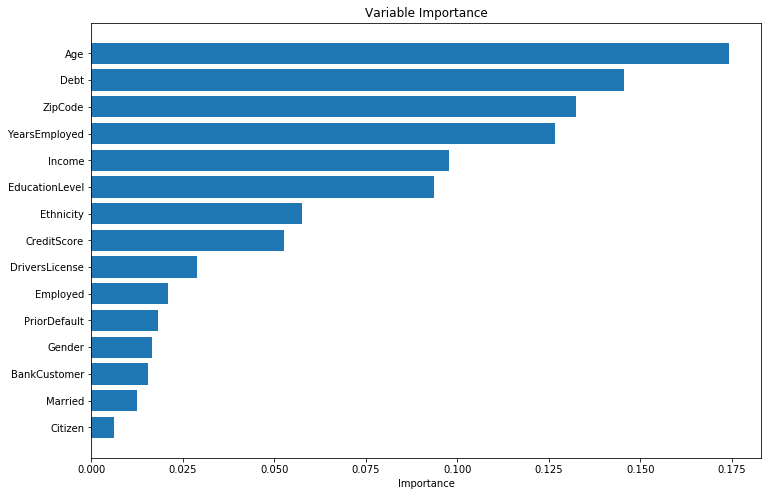

In [209]:
# Feature importance of gradient boost using the hypertuned parameters
rf_best = RandomForestClassifier(**rfclf_gridsearch.best_params_)
rf_best.fit(X_train, y_train)
feature_importance_rf = rf_best.feature_importances_
sorted_idx = np.argsort(feature_importance_rf)


pos= np.arange(sorted_idx.shape[0]) +0.5

plt.figure(figsize=(12,8))
plt.barh(pos,feature_importance_rf[sorted_idx], align='center')
plt.yticks(pos,X.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Variable Importance')
plt.show()

In [229]:
new_cols=X.columns[sorted_idx][1:].tolist()
new_X=X[new_cols]
#new_X_train, new_X_test, y_train, y_test = train_test_split(new_X,y, test_size = 0.3)

rf_new = RandomForestClassifier(**rfclf_gridsearch.best_params_)
#rf_new.fit(new_X_train, y_train)

''' since used the entire limited dataset, doing the same here'''
sco = cross_validate(rf_new, new_X,y, cv=5, scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), return_train_score = True)

scores ={'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'f1':[], 'roc_auc':[]}
sco['test_precision'].mean()
scores['Model'].append("New"+" " +type(rf_new).__name__)
scores['Accuracy'].append(sco['test_accuracy'].mean())
scores['Precision'].append(sco['test_precision'].mean())
scores['Recall'].append(sco['test_recall'].mean())
scores['f1'].append(sco['test_f1'].mean())
scores['roc_auc'].append(sco['test_roc_auc'].mean())
new_model_eval = pd.DataFrame(scores)

In [230]:
pd.concat([initial.iloc[[1]], randomized_rf, gridsearch_rf, new_model_eval])

,Model,Accuracy,Precision,Recall,f1,roc_auc
1,Initial RandomForestClassifier,0.820408,0.838825,0.781650,0.802612,0.890185
0,RF RandomizedSearchCV,0.850000,0.864728,0.835928,0.840125,0.923689
0,RF GridSearchCV,0.852576,0.858708,0.851354,0.845570,0.925029
0,New RandomForestClassifier,0.856588,0.859892,0.859545,0.850782,0.925864
